In [237]:
import concurrent.futures
import io
import warnings
from itertools import product, zip_longest

import demes
import demesdraw
import matplotlib.pyplot as plt
import moments
import msprime
import numpy as np
import tskit

warnings.filterwarnings("error")

In [238]:
SEED = 23

Ne = 5_000
r = 1e-6
rho = 4 * Ne * r
# L = 1_000_000
L = 10_000
mu = 1e-6
theta = 4 * Ne * mu

rho, theta

(0.02, 0.02)

In [239]:
ts = msprime.sim_ancestry(
    samples=1_000,
    population_size=Ne,
    sequence_length=L,
    recombination_rate=r,
    random_seed=SEED,
    discrete_genome=False,
)
ts = msprime.sim_mutations(ts, rate=mu, discrete_genome=False, random_seed=SEED)

In [240]:
def filter_invariant_sites(ts):
    allele_counts = np.zeros(ts.num_sites, dtype=np.int64)
    for tree in ts.trees():
        for m in tree.mutations():
            allele_counts[m.site] = tree.num_samples(m.node)
    assert allele_counts[allele_counts == 0].sum() == 0, "found alleles with 0 count"
    return np.where(allele_counts < ts.num_samples)[0].astype(np.int32)

In [241]:
assert len(filter_invariant_sites(ts)) == ts.num_sites
ts.num_sites

1799

In [242]:
def naive_ld_decay(ts, win_size, max_dist, **ld_kwargs):
    bins = np.arange(0, max_dist + 1, step=win_size)
    pos = ts.tables.sites.position
    result = np.zeros(len(bins) - 1, dtype=np.float64)
    dist = np.tril(np.subtract.outer(pos, pos))
    ld_matrix = ts.ld_matrix(**ld_kwargs)
    for i, (start, stop) in enumerate(zip(bins, bins[1:])):
        result[i] = np.nanmean(ld_matrix[(start < dist) & (dist <= stop)])
    return result

In [243]:
naive_decay_r2 = naive_ld_decay(ts, max_dist=1_000, win_size=10)

In [244]:
naive_decay_D2 = naive_ld_decay(ts, max_dist=1_000, win_size=10, stat="D2")

In [245]:
naive_decay_pi2 = naive_ld_decay(ts, max_dist=1_000, win_size=10, stat="pi2")

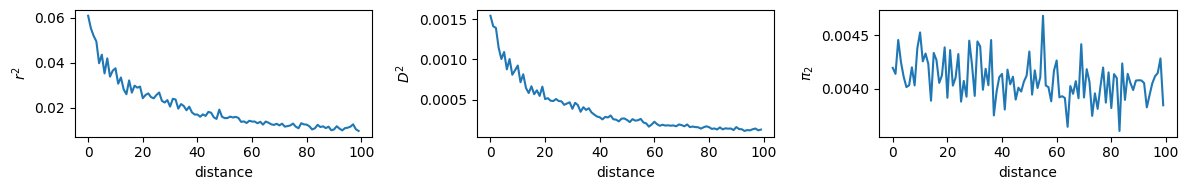

In [246]:
plt.subplots(1, 3, figsize=(12, 2))
plt.gcf().axes[0].plot(naive_decay_r2)
plt.gcf().axes[0].set_ylabel("$r^2$")
plt.gcf().axes[0].set_xlabel("distance")
plt.gcf().axes[1].plot(naive_decay_D2)
plt.gcf().axes[1].set_ylabel("$D^2$")
plt.gcf().axes[1].set_xlabel("distance")
plt.gcf().axes[2].plot(naive_decay_pi2)
plt.gcf().axes[2].set_ylabel(r"$\pi_2$")
plt.gcf().axes[2].set_xlabel("distance")
plt.tight_layout()

In [247]:
# def get_max_dist_slice(pos, max_dist):
#     bounds = np.vstack([pos + 1, pos + np.repeat(max_dist + 1, len(pos))]).T
#     for r in np.searchsorted(pos, bounds):
#         yield slice(*r)
def get_max_dist_slice(pos, max_dist):
    bounds = np.vstack([pos, pos + np.repeat(max_dist, len(pos))]).T
    for start, stop in np.searchsorted(pos, bounds):
        yield slice(start + 1, stop)


def chunks(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    i = 0
    for chunk in zip_longest(*args, fillvalue=fillvalue):
        yield i, tuple(filter(None, chunk))
        i += n


def bincount_unique(x, weights):
    # passes the following test...
    # bincount_unique(arr, np.ones_like(arr)) == np.unique(arr, return_counts=True)[1]
    # find breakpoints with closed invervals, starting with 0

    breaks = np.insert(np.where(x[1:] != x[:-1])[0] + 1, 0, 0)
    return np.add.reduceat(weights, breaks)

In [248]:
def iterative_ld_decay(ts, max_dist, win_size, **ld_kwargs):
    sites = np.arange(ts.num_sites, dtype=np.int32)
    pos = ts.tables.sites.position
    bins = np.arange(0, max_dist + 1, step=win_size)
    result = np.zeros(len(bins) - 1, dtype=np.float64)
    bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
    assert len(ld_kwargs.get('sample_sets', [])) <= 1, 'only one sample set allowed'
    for i, s in enumerate(get_max_dist_slice(pos, max_dist)):
        if 'sample_sets' in ld_kwargs:
            ld = ts.ld_matrix(sites=[[sites[i]], sites[s]], **ld_kwargs)[0][0]
        else:
            ld = ts.ld_matrix(sites=[[sites[i]], sites[s]], **ld_kwargs)[0]
        bin_idx = np.searchsorted(bins[1:], pos[s] - pos[i])
        bin_idx = bin_idx[~np.isnan(ld)]
        ld = ld[~np.isnan(ld)]
        if len(ld) == 0:
            continue
        bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
        bin_count[bin_idx_uniq] += bc
        # result[bin_idx_uniq] += np.bincount(bin_idx, weights=ld)
        result[bin_idx_uniq] += bincount_unique(bin_idx, ld)
        # assert (bincount_unique(bin_idx, np.ones_like(bin_idx)) == bc).all()

    return result / bin_count


# max_dist=1_000
# win_size=10
# sites = np.arange(ts.num_sites, dtype=np.int32)
# pos = ts.tables.sites.position
# bins = np.arange(0, max_dist + 1, step=win_size)
# result = np.zeros(len(bins) - 1, dtype=np.float64)
# bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
# for i, s in enumerate(get_max_dist_slice(pos, max_dist)):
#     ld = ts.ld_matrix(sites=[[sites[i]], sites[s]], stat='D2')[0]
#     bin_idx = np.searchsorted(bins[1:], pos[s] - pos[i])
#     bin_idx = bin_idx[~np.isnan(ld)]
#     ld = ld[~np.isnan(ld)]
#     if len(ld) == 0:
#         continue
#     bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
#     bin_count[bin_idx_uniq] += bc
#     # result[bin_idx_uniq] += np.bincount(bin_idx, weights=ld)
#     result[bin_idx_uniq] += bincount_unique(bin_idx, ld)
#     # assert (bincount_unique(bin_idx, np.ones_like(bin_idx)) == bc).all()

In [249]:
# punt on this for now

# max_dist=100_000
# win_size=100
# sites = np.arange(ts.num_sites, dtype=np.int32)
# pos = ts.tables.sites.position
# bins = np.arange(0, max_dist + 1, step=win_size)
# result = np.zeros(len(bins) - 1, dtype=np.float64)
# bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
# # num_sample_sets = len(kwargs.get('sample_sets', []))
# num_sample_sets = 2
# for i, s in enumerate(get_max_dist_slice(pos, max_dist)):
#     ld = ts.ld_matrix(sites=[[sites[i]], sites[s]], sample_sets=[ts.samples(1), ts.samples(2)], stat="D2")
#     if num_sample_sets > 0:
#         ld = ld[:, 0, :]
#     else:
#         ld = ld[0]
#     bin_idx = np.searchsorted(bins[1:], pos[s] - pos[i])
#     bin_idx = [bin_idx] * num_sample_sets
#     # bin_idx = np.tile(bin_idx, num_sample_sets).reshape(num_sample_sets, len(bin_idx))
#     # bin_idx = bin_idx[~np.isnan(ld)]
#     # ld = ld[~np.isnan(ld)]
#     # if len(ld) == 0:
#     #     continue
#     break
#     bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
#     bin_count[bin_idx_uniq] += bc
#     # result[bin_idx_uniq] += np.bincount(bin_idx, weights=ld)
#     result[bin_idx_uniq] += bincount_unique(bin_idx, ld)
#     # assert (bincount_unique(bin_idx, np.ones_like(bin_idx)) == bc).all()

In [250]:
def chunked_iterative_ld_decay(ts, max_dist, win_size, chunk_size, **ld_kwargs):
    sites = np.arange(ts.num_sites, dtype=np.int32)
    pos = ts.tables.sites.position
    bins = np.arange(0, max_dist + 1, step=win_size)
    result = np.zeros(len(bins) - 1, dtype=np.float64)
    bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
    assert len(ld_kwargs.get('sample_sets', [])) <= 1, 'only one sample set allowed'
    for i, (c_i, chunk) in enumerate(
        chunks(get_max_dist_slice(pos, max_dist), chunk_size)
    ):
        chunk_slice = slice(chunk[0].start - 1, chunk[-1].stop)
        if 'sample_sets' in ld_kwargs:
            ld = ts.ld_matrix(
                sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
            )[0]
        else:            
            ld = ts.ld_matrix(
                sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
            )
        for k, (j, s) in enumerate(enumerate(chunk, c_i)):
            ld_row = ld[k, sites[s] - c_i]  # implicit copy
            bin_idx = np.searchsorted(bins[1:], pos[s] - pos[j])
            bin_idx = bin_idx[~np.isnan(ld_row)]
            ld_row = ld_row[~np.isnan(ld_row)]
            if len(ld_row) == 0:
                continue
            bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
            bin_count[bin_idx_uniq] += bc
            result[bin_idx_uniq] += bincount_unique(bin_idx, ld_row)
            assert (bincount_unique(bin_idx, np.ones_like(bin_idx)) == bc).all()

    return result / bin_count

In [260]:
def parallel_chunked_iterative_ld_decay(
    ts, max_dist, win_size, chunk_size, n_threads, **ld_kwargs
):
    sites = np.arange(ts.num_sites, dtype=np.int32)
    pos = ts.tables.sites.position
    bins = np.arange(0, max_dist + 1, step=win_size)
    assert len(ld_kwargs.get('sample_sets', [])) <= 1, 'only one sample set allowed'

    def worker(args):
        i, (c_i, chunk) = args
        result = np.zeros(len(bins) - 1, dtype=np.float64)
        bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
        chunk_slice = slice(chunk[0].start - 1, chunk[-1].stop)
        if 'sample_sets' in ld_kwargs:
            ld = ts.ld_matrix(
                sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
            )[0]
        else:            
            ld = ts.ld_matrix(
                sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
            )
        for k, (j, s) in enumerate(enumerate(chunk, c_i)):
            ld_row = ld[k, sites[s] - c_i]  # implicit copy
            bin_idx = np.searchsorted(bins[1:], pos[s] - pos[j])
            bin_idx = bin_idx[~np.isnan(ld_row)]
            ld_row = ld_row[~np.isnan(ld_row)]
            if len(ld_row) == 0:
                continue
            bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
            bin_count[bin_idx_uniq] += bc
            result[bin_idx_uniq] += bincount_unique(bin_idx, ld_row)
        return result, bin_count

    work = enumerate(chunks(get_max_dist_slice(pos, max_dist), chunk_size))
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as pool:
        results = pool.map(worker, work)
    result = []
    bin_count = []
    for r, bc in results:
        result.append(r)
        bin_count.append(bc)
    return np.vstack(result).sum(0) / np.vstack(bin_count).sum(0)

In [263]:
def parallel_chunked_iterative_ld_decay_two_way(
    ts, max_dist, win_size, chunk_size, n_threads, **ld_kwargs
):
    sites = np.arange(ts.num_sites, dtype=np.int32)
    pos = ts.tables.sites.position
    bins = np.arange(0, max_dist + 1, step=win_size)

    def worker(args):
        i, (c_i, chunk) = args
        result = np.zeros(len(bins) - 1, dtype=np.float64)
        bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
        chunk_slice = slice(chunk[0].start - 1, chunk[-1].stop)
        ld = ts.ld_matrix_two_way(
            sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
        )
        for k, (j, s) in enumerate(enumerate(chunk, c_i)):
            ld_row = ld[k, sites[s] - c_i]  # implicit copy
            bin_idx = np.searchsorted(bins[1:], pos[s] - pos[j])
            bin_idx = bin_idx[~np.isnan(ld_row)]
            ld_row = ld_row[~np.isnan(ld_row)]
            if len(ld_row) == 0:
                continue
            bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
            bin_count[bin_idx_uniq] += bc
            result[bin_idx_uniq] += bincount_unique(bin_idx, ld_row)
        return result, bin_count

    work = enumerate(chunks(get_max_dist_slice(pos, max_dist), chunk_size))
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as pool:
        results = pool.map(worker, work)
    result = []
    bin_count = []
    for r, bc in results:
        result.append(r)
        bin_count.append(bc)
    return np.vstack(result).sum(0) / np.vstack(bin_count).sum(0)

In [253]:
# max_dist=1_000
# win_size=10
# sites = np.arange(ts.num_sites, dtype=np.int32)
# pos = ts.tables.sites.position
# bins = np.arange(0, max_dist + 1, step=win_size)
# result = np.zeros(len(bins) - 1, dtype=np.float64)
# bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
# for i, s in enumerate(get_max_dist_slice(pos, max_dist)):
#     ld = ts.ld_matrix(sites=[[sites[i]], sites[s]], stat='D2')[0]
#     bin_idx = np.searchsorted(bins[1:], pos[s] - pos[i])
#     bin_idx = bin_idx[~np.isnan(ld)]
#     ld = ld[~np.isnan(ld)]
#     if len(ld) == 0:
#         continue
#     bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
#     bin_count[bin_idx_uniq] += bc
#     # result[bin_idx_uniq] += np.bincount(bin_idx, weights=ld)
#     result[bin_idx_uniq] += bincount_unique(bin_idx, ld)
#     # assert (bincount_unique(bin_idx, np.ones_like(bin_idx)) == bc).all()

In [256]:
iterative_decay_r2 = iterative_ld_decay(ts, max_dist=1_000, win_size=10)
iterative_decay_D2 = iterative_ld_decay(ts, max_dist=1_000, win_size=10, stat="D2")
iterative_decay_pi2 = iterative_ld_decay(ts, max_dist=1_000, win_size=10, stat="pi2")

iterative_decay_ss_r2 = iterative_ld_decay(ts, max_dist=1_000, win_size=10, sample_sets=[ts.samples()])
iterative_decay_ss_D2 = iterative_ld_decay(ts, max_dist=1_000, win_size=10, stat="D2", sample_sets=[ts.samples()])
iterative_decay_ss_pi2 = iterative_ld_decay(ts, max_dist=1_000, win_size=10, stat="pi2", sample_sets=[ts.samples()])

In [258]:
print(np.isclose(iterative_decay_r2, naive_decay_r2).all())
print(np.isclose(iterative_decay_D2, naive_decay_D2).all())
print(np.isclose(iterative_decay_pi2, naive_decay_pi2).all())

print(np.isclose(iterative_decay_ss_r2, naive_decay_r2).all())
print(np.isclose(iterative_decay_ss_D2, naive_decay_D2).all())
print(np.isclose(iterative_decay_ss_pi2, naive_decay_pi2).all())

True
True
True
True
True
True


In [259]:
# fmt: off
print((chunked_iterative_ld_decay(ts, 1_000, 10, 10) == iterative_decay_r2).all())
print((chunked_iterative_ld_decay(ts, 1_000, 10, 10, stat="D2") == iterative_decay_D2).all())
print((chunked_iterative_ld_decay(ts, 1_000, 10, 10, stat="pi2") == iterative_decay_pi2).all())

print((chunked_iterative_ld_decay(ts, 1_000, 10, 10, sample_sets=[ts.samples()]) == iterative_decay_r2).all())
print((chunked_iterative_ld_decay(ts, 1_000, 10, 10, stat="D2", sample_sets=[ts.samples()]) == iterative_decay_D2).all())
print((chunked_iterative_ld_decay(ts, 1_000, 10, 10, stat="pi2", sample_sets=[ts.samples()]) == iterative_decay_pi2).all())

True
True
True
True
True
True


In [264]:
# fmt: off
print(np.isclose(parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15), naive_decay_r2).all())
print(np.isclose(parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15, stat='D2'), naive_decay_D2).all())
print(np.isclose(parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15, stat='pi2'), naive_decay_pi2).all())

print(np.isclose(parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15, sample_sets=[ts.samples()]), naive_decay_r2).all())
print(np.isclose(parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15, stat='D2', sample_sets=[ts.samples()]), naive_decay_D2).all())
print(np.isclose(parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15, stat='pi2', sample_sets=[ts.samples()]), naive_decay_pi2).all())

True
True
True
True
True
True


In [265]:
# fmt: off
print(np.isclose(parallel_chunked_iterative_ld_decay_two_way(
        ts, 1_000, 10, 10, 15, stat='r2_ij', sample_sets=[ts.samples(), ts.samples()]), naive_decay_r2).all())
print(np.isclose(parallel_chunked_iterative_ld_decay_two_way(
        ts, 1_000, 10, 10, 15, stat='D2_ij', sample_sets=[ts.samples(), ts.samples()]), naive_decay_D2).all())

True
True


In [266]:
%timeit naive_ld_decay(ts, max_dist=1_000, win_size=10)

1.95 s ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [267]:
%timeit iterative_ld_decay(ts, max_dist=1_000, win_size=10)

1.06 s ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [268]:
%timeit chunked_iterative_ld_decay(ts, 1_000, 10, 10)

332 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [269]:
%timeit parallel_chunked_iterative_ld_decay(ts, 1_000, 10, 10, 15)

153 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [270]:
1.95 / 153e-3

12.745098039215685

~13x improvement over naive

In [33]:
L = 100_000
ts = msprime.sim_ancestry(
    samples=1_000,
    population_size=Ne,
    sequence_length=L,
    recombination_rate=r,
    random_seed=SEED,
    discrete_genome=False,
)
ts = msprime.sim_mutations(ts, rate=mu, random_seed=SEED, discrete_genome=False)

In [34]:
assert len(filter_invariant_sites(ts)) == ts.num_sites
ts.num_sites, ts.num_mutations

(16202, 16202)

In [35]:
%%time
decay_serial = chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100
)

CPU times: user 1min 15s, sys: 1.07 ms, total: 1min 15s
Wall time: 1min 15s


In [36]:
%%time
decay = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15
)

CPU times: user 2min 2s, sys: 563 ms, total: 2min 3s
Wall time: 8.45 s


~60% efficiency

In [37]:
np.isclose(decay_serial, decay).all()

True

In [55]:
decay_r2 = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15
)
decay_D2 = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15, stat="D2_unbiased"
)
decay_pi2 = parallel_chunked_iterative_ld_decay(
    ts,
    max_dist=100_000,
    win_size=100,
    chunk_size=100,
    n_threads=15,
    stat="pi2_unbiased",
)

Text(0.5, 0, 'distance')

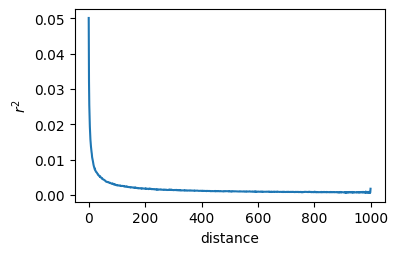

In [56]:
plt.subplots(figsize=(4, 2.5))
plt.plot(decay)
plt.ylabel("$r^2$")
plt.xlabel("distance")
# plt.xscale("log")

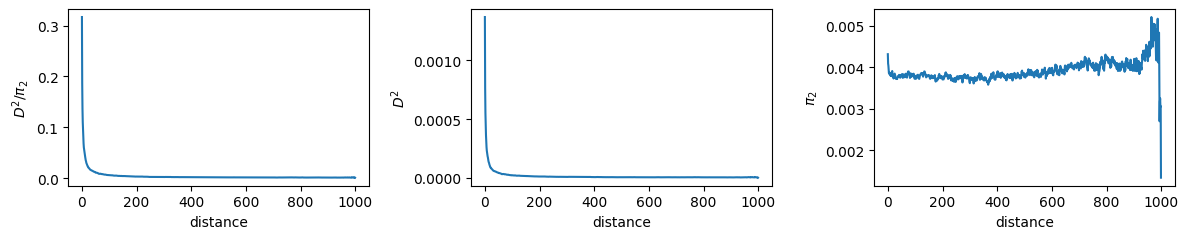

In [40]:
plt.subplots(1, 3, figsize=(12, 2.5))
plt.gcf().axes[0].plot(decay_D2 / decay_pi2)
plt.gcf().axes[0].set_ylabel(r"$D^2/\pi_2$")
plt.gcf().axes[0].set_xlabel("distance")
plt.gcf().axes[1].plot(decay_D2)
plt.gcf().axes[1].set_ylabel("$D^2$")
plt.gcf().axes[1].set_xlabel("distance")
plt.gcf().axes[2].plot(decay_pi2)
plt.gcf().axes[2].set_ylabel(r"$\pi_2$")
plt.gcf().axes[2].set_xlabel("distance")
plt.tight_layout()

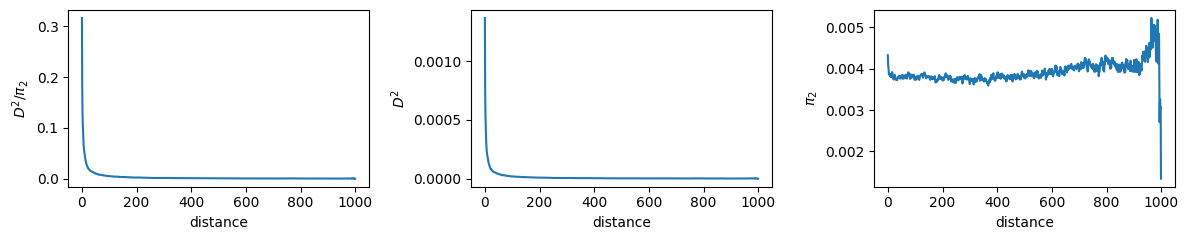

In [57]:
plt.subplots(1, 3, figsize=(12, 2.5))
plt.gcf().axes[0].plot(decay_D2 / decay_pi2)
plt.gcf().axes[0].set_ylabel(r"$D^2/\pi_2$")
plt.gcf().axes[0].set_xlabel("distance")
plt.gcf().axes[1].plot(decay_D2)
plt.gcf().axes[1].set_ylabel("$D^2$")
plt.gcf().axes[1].set_xlabel("distance")
plt.gcf().axes[2].plot(decay_pi2)
plt.gcf().axes[2].set_ylabel(r"$\pi_2$")
plt.gcf().axes[2].set_xlabel("distance")
plt.tight_layout()

In [69]:
b = np.arange(0, 100_000 + 1, step=100)
bin_mids = (b[1:] + b[:-1]) / 2

moments_edges_result = moments.LD.Demographics1D.snm(rho=b * rho, theta=theta)

moments_mids_result = moments.LD.Demographics1D.snm(
    rho=bin_mids * rho,
    theta=theta,
)

moments_mids_ld_stats = np.vstack(moments_mids_result[:-1])
moments_mids_D2 = moments_mids_ld_stats[:, 0]
moments_mids_Dz = moments_mids_ld_stats[:, 1]
moments_mids_pi2 = moments_mids_ld_stats[:, 2]
moments_edges_ld_stats = np.vstack(moments_edges_result[:-1])
moments_edges_D2 = moments_edges_ld_stats[:, 0]
moments_edges_Dz = moments_edges_ld_stats[:, 1]
moments_edges_pi2 = moments_edges_ld_stats[:, 2]

In [ ]:
# moments_left = moments.LD.Demographics1D.snm(
#     rho=bin_mids * rho,
#     theta=theta,
# )
# moments_ld_stats = np.vstack(moments_result[:-1])
# moments_D2 = moments_ld_stats[:, 0]
# moments_Dz = moments_ld_stats[:, 1]
# moments_pi2 = moments_ld_stats[:, 2]

In [70]:
moments_D2 = (moments_edges_D2[:-1] + 4 * moments_mids_D2 + moments_edges_D2[1:]) / 6
moments_pi2 = (
    moments_edges_pi2[:-1] + 4 * moments_mids_pi2 + moments_edges_pi2[1:]
) / 6

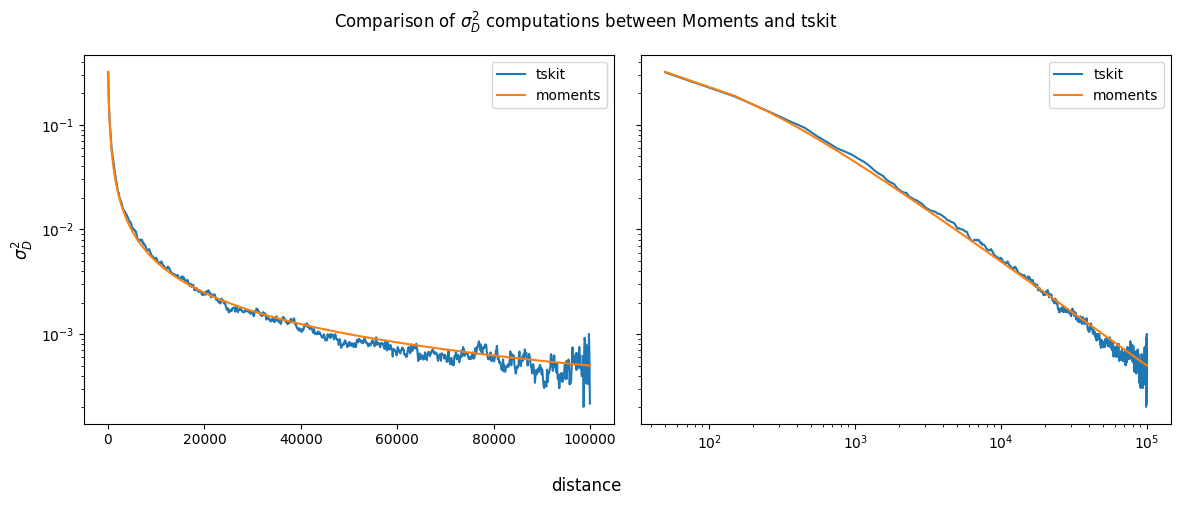

In [60]:
plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.gcf().axes[0].plot(bin_mids, decay_d2 / decay_pi2, label="tskit")
plt.gcf().axes[0].plot(bin_mids, moments_d2 / moments_pi2, label="moments")
plt.gcf().axes[0].legend()
plt.gcf().axes[1].plot(bin_mids, decay_d2 / decay_pi2, label="tskit")
plt.gcf().axes[1].plot(bin_mids, moments_d2 / moments_pi2, label="moments")
plt.gcf().axes[1].set_xscale("log")
plt.gcf().axes[1].set_yscale("log")
plt.gcf().axes[1].legend()
plt.gcf().supylabel(r"$\sigma_d^2$")
plt.gcf().supxlabel("distance")
plt.suptitle(r"comparison of $\sigma_d^2$ computations between moments and tskit")
plt.tight_layout()

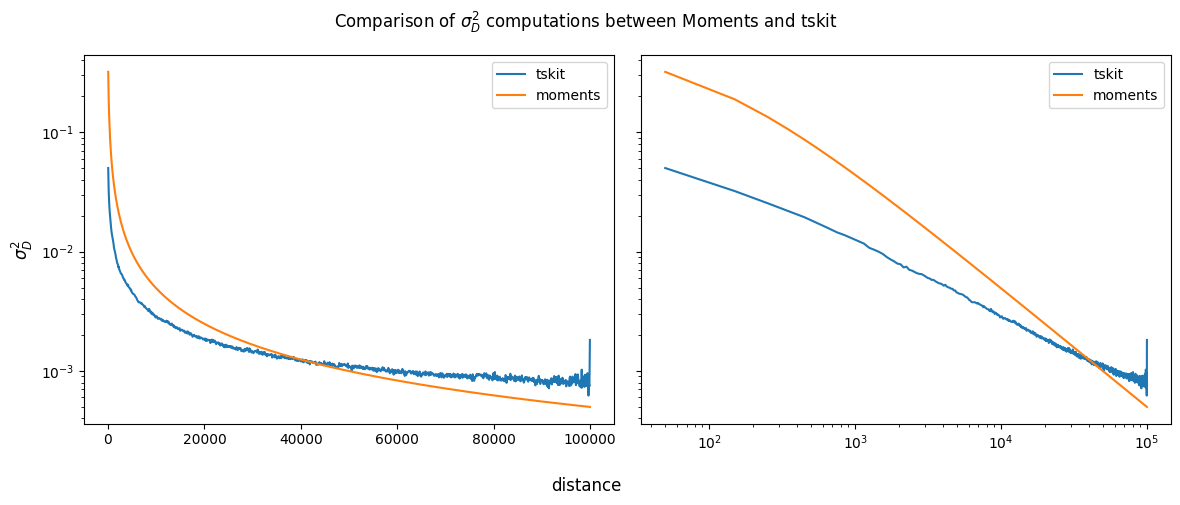

In [62]:
plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.gcf().axes[0].plot(bin_mids, decay_r2, label="tskit")
plt.gcf().axes[0].plot(bin_mids, moments_D2 / moments_pi2, label="moments")
plt.gcf().axes[0].legend()
plt.gcf().axes[1].plot(bin_mids, decay_r2, label="tskit")
plt.gcf().axes[1].plot(bin_mids, moments_D2 / moments_pi2, label="moments")
plt.gcf().axes[1].set_xscale("log")
plt.gcf().axes[1].set_yscale("log")
plt.gcf().axes[1].legend()
plt.gcf().supylabel(r"$\sigma_D^2$")
plt.gcf().supxlabel("distance")
plt.suptitle(r"Comparison of $\sigma_D^2$ computations between Moments and tskit")
plt.tight_layout()

In [122]:
demog = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      - end_time: 1000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
"""
    )
)

In [123]:
ts = msprime.sim_ancestry(
    # {"A": 40, "B": 40},
    samples=[
        msprime.SampleSet(40, population="A", time=0),
        msprime.SampleSet(40, population="B", time=0),
    ],
    sequence_length=1e6,
    recombination_rate=1e-7,
    demography=msprime.Demography.from_demes(demog),
    random_seed=SEED,
    discrete_genome=False
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=SEED, discrete_genome=False)

In [124]:
msprime.Demography.from_demes(demog)

Demography(populations=[Population(initial_size=0, growth_rate=0, name='X', description='', extra_metadata={}, default_sampling_time=1000.0, initially_active=False, id=0), Population(initial_size=5000, growth_rate=0, name='A', description='', extra_metadata={}, default_sampling_time=0.0, initially_active=True, id=1), Population(initial_size=5000, growth_rate=0, name='B', description='', extra_metadata={}, default_sampling_time=0.0, initially_active=True, id=2)], events=[PopulationParametersChange(time=1000.0, initial_size=5000, growth_rate=None, population='X'), PopulationSplit(time=1000.0, derived=['B', 'A'], ancestral='X')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

In [125]:
within_decay_D2 = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15, stat="D2"
    # ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15, stat="D2", sample_sets=[ts.samples(1)]
)
within_decay_pi2 = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15, stat="pi2"
    # ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15, stat="pi2", sample_sets=[ts.samples(1)]
)
# cross_pop_decay_nomig = parallel_chunked_iterative_ld_decay_two_way(
#     ts,
#     max_dist=100_000,
#     win_size=100,
#     chunk_size=100,
#     n_threads=15,
#     stat="r2_ij",
#     sample_sets=[ts.samples(population=1), ts.samples(population=2)],
# )

In [178]:
b = np.arange(0, 100_000 + 1, step=100)
bin_mids = (b[1:] + b[:-1]) / 2

moments_mids_result = moments.Demes.LD(
    demog,
    sampled_demes=["A", "B"],
    sample_times=[0, 0],
    rho=1e-7 * 4 * 5_000 * bin_mids,
    theta=1e-7 * 4 * 5_000,
)
moments_edges_result = moments.LD.Demographics1D.snm(rho=b * 1e-7 * 4 * 5_000, theta=1e-7 * 4 * 5_000)

moments_mids_ld_stats = np.vstack(moments_mids_result[:-1])
moments_mids_D2 = moments_mids_ld_stats[:, 0]
moments_mids_Dz = moments_mids_ld_stats[:, 1]
moments_mids_pi2 = moments_mids_ld_stats[:, 2]
moments_edges_ld_stats = np.vstack(moments_edges_result[:-1])
moments_edges_D2 = moments_edges_ld_stats[:, 0]
moments_edges_Dz = moments_edges_ld_stats[:, 1]
moments_edges_pi2 = moments_edges_ld_stats[:, 2]

moments_D2 = (moments_edges_D2[:-1] + 4 * moments_mids_D2 + moments_edges_D2[1:]) / 6
moments_pi2 = (
    moments_edges_pi2[:-1] + 4 * moments_mids_pi2 + moments_edges_pi2[1:]
) / 6

In [181]:
moments_mids_result.names()

(['DD_0_0',
  'DD_0_1',
  'DD_1_1',
  'Dz_0_0_0',
  'Dz_0_0_1',
  'Dz_0_1_1',
  'Dz_1_0_0',
  'Dz_1_0_1',
  'Dz_1_1_1',
  'pi2_0_0_0_0',
  'pi2_0_0_0_1',
  'pi2_0_0_1_1',
  'pi2_0_1_0_1',
  'pi2_0_1_1_1',
  'pi2_1_1_1_1'],
 ['H_0_0', 'H_0_1', 'H_1_1'])

In [179]:
moments_edges_result

LDstats([[5.55555556e-07 4.44444444e-07 1.22222222e-06]
 [4.94186047e-07 3.87596899e-07 1.19379845e-06]
 [4.45205479e-07 3.42465753e-07 1.17123288e-06]
 ...
 [4.93722935e-09 1.88443868e-10 1.00009422e-06]
 [4.93235758e-09 1.88078459e-10 1.00009404e-06]
 [4.92749542e-09 1.87714111e-10 1.00009386e-06]], [0.002], num_pops=1, pop_ids=None)

In [180]:
moments_edges_result.names()

(['DD_0_0', 'Dz_0_0_0', 'pi2_0_0_0_0'], ['H_0_0'])

In [130]:
moments.LD.Inference.sigmaD2(moments_mids_result).names()

(['DD_0_0',
  'DD_0_1',
  'DD_1_1',
  'Dz_0_0_0',
  'Dz_0_0_1',
  'Dz_0_1_1',
  'Dz_1_0_0',
  'Dz_1_0_1',
  'Dz_1_1_1',
  'pi2_0_0_0_0',
  'pi2_0_0_0_1',
  'pi2_0_0_1_1',
  'pi2_0_1_0_1',
  'pi2_0_1_1_1',
  'pi2_1_1_1_1'],
 ['H_0_0', 'H_0_1', 'H_1_1'])

In [127]:
moments_edges_result.names()

(['DD_0_0', 'Dz_0_0_0', 'pi2_0_0_0_0'], ['H_0_0'])

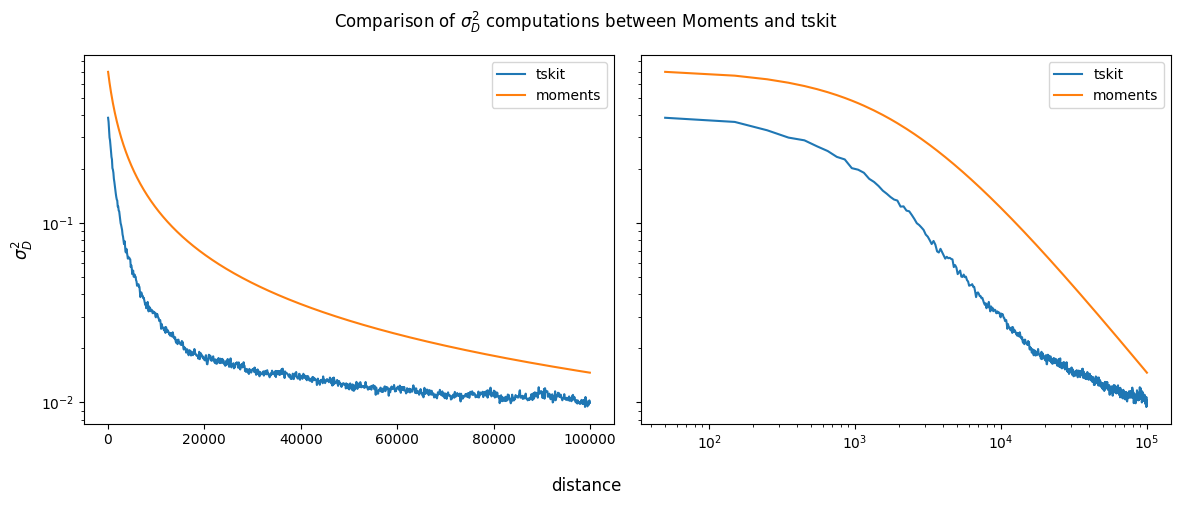

In [128]:
plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.gcf().axes[0].plot(bin_mids, within_decay_D2 / within_decay_pi2, label="tskit")
plt.gcf().axes[0].plot(bin_mids, moments_D2 / moments_pi2, label="moments")
plt.gcf().axes[0].legend()
plt.gcf().axes[1].plot(bin_mids, within_decay_D2 / within_decay_pi2, label="tskit")
plt.gcf().axes[1].plot(bin_mids, moments_D2 / moments_pi2, label="moments")
plt.gcf().axes[1].set_xscale("log")
plt.gcf().axes[1].set_yscale("log")
plt.gcf().axes[1].legend()
plt.gcf().supylabel(r"$\sigma_D^2$")
plt.gcf().supxlabel("distance")
plt.suptitle(r"Comparison of $\sigma_D^2$ computations between Moments and tskit")
plt.tight_layout()

In [66]:
demog = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      - end_time: 1000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
"""
    )
)

<Axes: ylabel='time ago (generations)'>

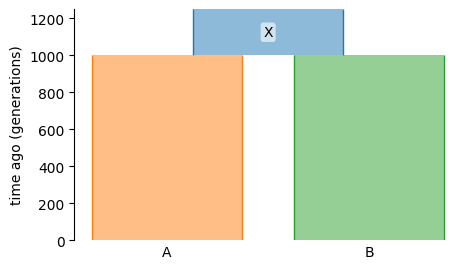

In [36]:
plt.subplots(figsize=(5, 3))
demesdraw.tubes(demog, ax=plt.gca())

In [37]:
ts = msprime.sim_ancestry(
    # {"A": 40, "B": 40},
    samples=[
        msprime.SampleSet(40, population="A"),
        msprime.SampleSet(40, population="B"),
    ],
    sequence_length=1e6,
    recombination_rate=1e-7,
    demography=msprime.Demography.from_demes(demog),
    random_seed=SEED,
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=SEED)

In [38]:
ts

In [39]:
list(ts.populations())

[Population(id=0, metadata={'description': '', 'name': 'X'}),
 Population(id=1, metadata={'description': '', 'name': 'A'}),
 Population(id=2, metadata={'description': '', 'name': 'B'})]

In [40]:
within_pop_decay_nomig = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15
)
cross_pop_decay_nomig = parallel_chunked_iterative_ld_decay_two_way(
    ts,
    max_dist=100_000,
    win_size=100,
    chunk_size=100,
    n_threads=15,
    stat="r2_ij",
    sample_sets=[ts.samples(population=1), ts.samples(population=2)],
)

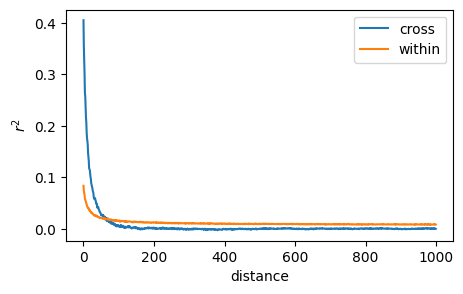

In [41]:
plt.subplots(figsize=(5, 3))
plt.plot(cross_pop_decay_nomig, label="cross")
plt.plot(within_pop_decay_nomig, label="within")
plt.ylabel("$r^2$")
plt.xlabel("distance")
plt.legend()

In [42]:
demog = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      - end_time: 1000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
migrations:
  - demes: [A, B]
    rate: 1e-4
"""
    )
)

<Axes: ylabel='time ago (generations)'>

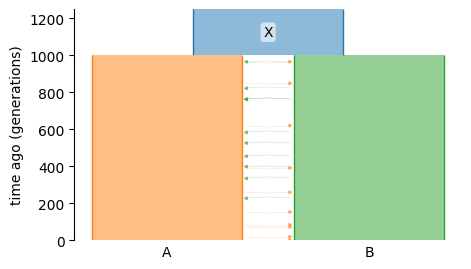

In [43]:
plt.subplots(figsize=(5, 3))
demesdraw.tubes(demog, ax=plt.gca())

In [44]:
ts = msprime.sim_ancestry(
    # {"A": 40, "B": 40},
    samples=[
        msprime.SampleSet(40, population="A"),
        msprime.SampleSet(40, population="B"),
    ],
    sequence_length=1e6,
    recombination_rate=1e-7,
    demography=msprime.Demography.from_demes(demog),
    random_seed=SEED,
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=SEED)

In [45]:
ts

In [46]:
list(ts.populations())

[Population(id=0, metadata={'description': '', 'name': 'X'}),
 Population(id=1, metadata={'description': '', 'name': 'A'}),
 Population(id=2, metadata={'description': '', 'name': 'B'})]

In [47]:
within_pop_decay_lowmig = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15
)
cross_pop_decay_lowmig = parallel_chunked_iterative_ld_decay_two_way(
    ts,
    max_dist=100_000,
    win_size=100,
    chunk_size=100,
    n_threads=15,
    stat="r2_ij",
    sample_sets=[ts.samples(population=1), ts.samples(population=2)],
)

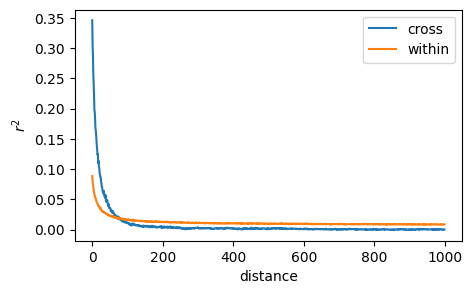

In [48]:
plt.subplots(figsize=(5, 3))
plt.plot(cross_pop_decay_lowmig, label="cross")
plt.plot(within_pop_decay_lowmig, label="within")
plt.ylabel("$r^2$")
plt.xlabel("distance")
plt.legend()

In [49]:
demog = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      - end_time: 1000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
migrations:
  - demes: [A, B]
    rate: 1e-2
"""
    )
)

<Axes: ylabel='time ago (generations)'>

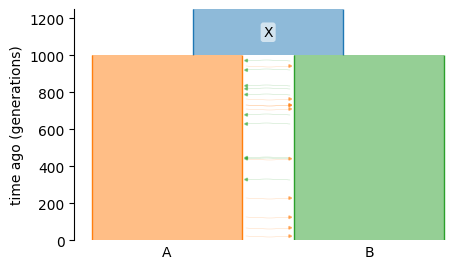

In [50]:
plt.subplots(figsize=(5, 3))
demesdraw.tubes(demog, ax=plt.gca())

In [51]:
ts = msprime.sim_ancestry(
    # {"A": 40, "B": 40},
    samples=[
        msprime.SampleSet(40, population="A"),
        msprime.SampleSet(40, population="B"),
    ],
    sequence_length=1e6,
    recombination_rate=1e-7,
    demography=msprime.Demography.from_demes(demog),
    random_seed=SEED,
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=SEED)

In [52]:
ts

In [53]:
list(ts.populations())

[Population(id=0, metadata={'description': '', 'name': 'X'}),
 Population(id=1, metadata={'description': '', 'name': 'A'}),
 Population(id=2, metadata={'description': '', 'name': 'B'})]

In [54]:
within_pop_decay_highmig = parallel_chunked_iterative_ld_decay(
    ts, max_dist=100_000, win_size=100, chunk_size=100, n_threads=15
)
cross_pop_decay_highmig = parallel_chunked_iterative_ld_decay_two_way(
    ts,
    max_dist=100_000,
    win_size=100,
    chunk_size=100,
    n_threads=15,
    stat="r2_ij",
    sample_sets=[ts.samples(population=1), ts.samples(population=2)],
)

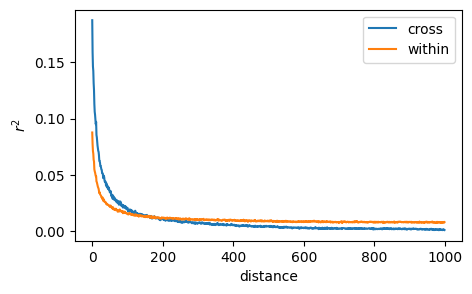

In [55]:
plt.subplots(figsize=(5, 3))
plt.plot(cross_pop_decay_highmig, label="cross")
plt.plot(within_pop_decay_highmig, label="within")
plt.ylabel("$r^2$")
plt.xlabel("distance")
plt.legend()

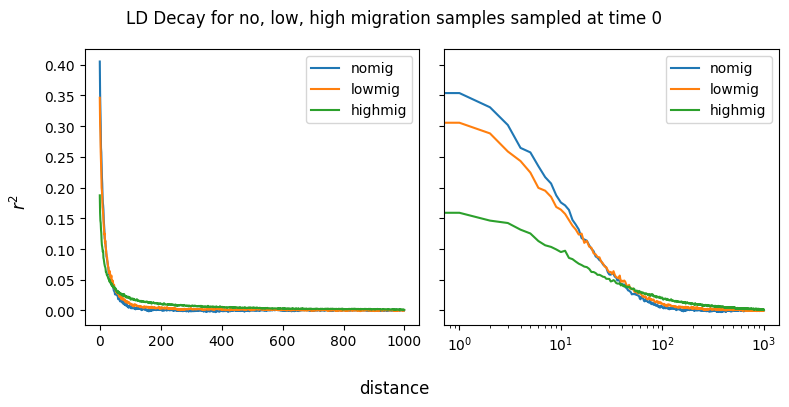

In [56]:
plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.gcf().axes[0].plot(cross_pop_decay_nomig, label="nomig")
plt.gcf().axes[0].plot(cross_pop_decay_lowmig, label="lowmig")
plt.gcf().axes[0].plot(cross_pop_decay_highmig, label="highmig")
plt.gcf().axes[0].legend()
plt.gcf().axes[1].plot(cross_pop_decay_nomig, label="nomig")
plt.gcf().axes[1].plot(cross_pop_decay_lowmig, label="lowmig")
plt.gcf().axes[1].plot(cross_pop_decay_highmig, label="highmig")
plt.gcf().axes[1].legend()
plt.gcf().axes[1].set_xscale("log")
plt.legend()
plt.gcf().supxlabel("distance")
plt.gcf().supylabel("$r^2$")
plt.suptitle("LD Decay for no, low, high migration samples sampled at time 0")
plt.tight_layout()

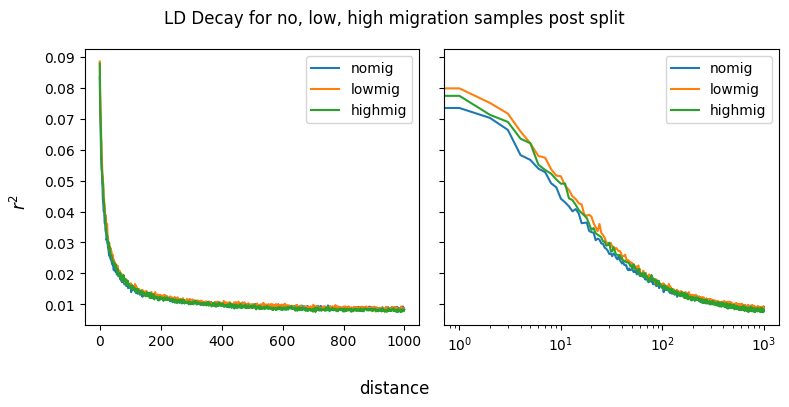

In [57]:
plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.gcf().axes[0].plot(within_pop_decay_nomig, label="nomig")
plt.gcf().axes[0].plot(within_pop_decay_lowmig, label="lowmig")
plt.gcf().axes[0].plot(within_pop_decay_highmig, label="highmig")
plt.gcf().axes[0].legend()
plt.gcf().axes[1].plot(within_pop_decay_nomig, label="nomig")
plt.gcf().axes[1].plot(within_pop_decay_lowmig, label="lowmig")
plt.gcf().axes[1].plot(within_pop_decay_highmig, label="highmig")
plt.gcf().axes[1].legend()
plt.gcf().axes[1].set_xscale("log")
plt.legend()
plt.gcf().supxlabel("distance")
plt.gcf().supylabel("$r^2$")
plt.suptitle("LD Decay for no, low, high migration samples post split")
plt.tight_layout()

In [58]:
demog = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      # - end_time: 1000
      - end_time: 5000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
"""
    )
)

<Axes: ylabel='time ago (generations)'>

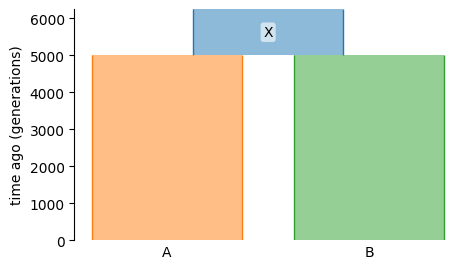

In [59]:
plt.subplots(figsize=(5, 3))
demesdraw.tubes(demog, ax=plt.gca())

In [60]:
# times = [999, 800, 600, 400, 200, 0]
times = [4999, 3000, 2000, 1000, 500, 0]
ts = msprime.sim_ancestry(
    # {"A": 40, "B": 40},
    samples=[
        msprime.SampleSet(40, population=p, time=t)
        for p, t in product(["A", "B"], times)
    ],
    sequence_length=1e6,
    recombination_rate=1e-7,
    demography=msprime.Demography.from_demes(demog),
    random_seed=SEED,
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=SEED)

In [61]:
ts

In [62]:
list(ts.populations())

[Population(id=0, metadata={'description': '', 'name': 'X'}),
 Population(id=1, metadata={'description': '', 'name': 'A'}),
 Population(id=2, metadata={'description': '', 'name': 'B'})]

In [63]:
a_sample_sets = [ts.samples(1, time=t) for t in times]
b_sample_sets = [ts.samples(2, time=t) for t in times]

In [64]:
decays = []
for a, b in zip(a_sample_sets, b_sample_sets):
    decays.append(
        parallel_chunked_iterative_ld_decay_two_way(
            ts,
            max_dist=100_000,
            win_size=100,
            chunk_size=100,
            n_threads=15,
            stat="r2_ij",
            sample_sets=[a, b],
        )
    )

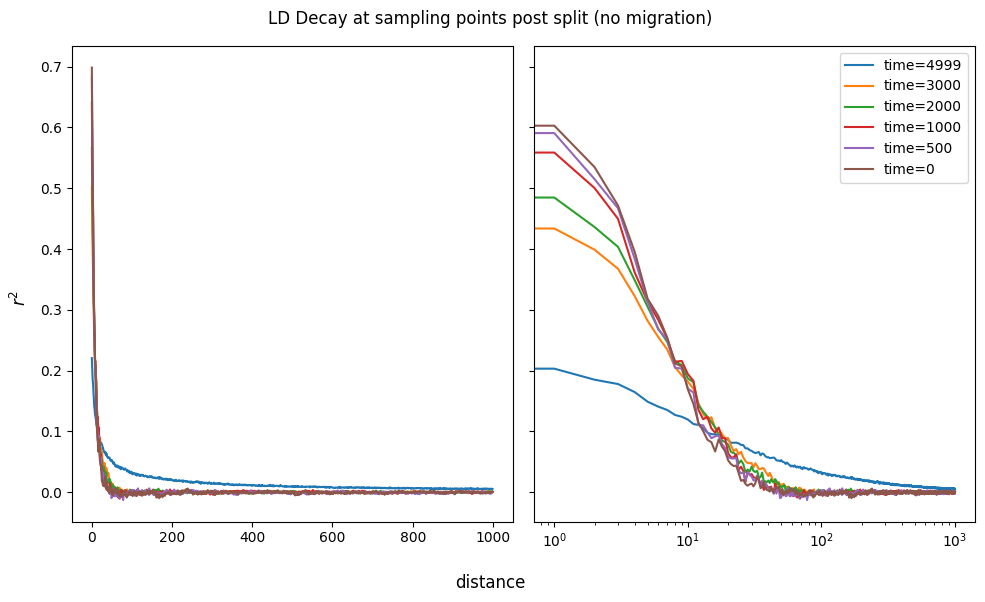

In [65]:
plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for t, d in zip(times, decays):
    plt.gcf().axes[0].plot(d, label=f"time={t}")
for t, d in zip(times, decays):
    plt.gcf().axes[1].plot(d, label=f"time={t}")
plt.legend()
plt.gcf().axes[1].set_xscale("log")
plt.gcf().supxlabel("distance")
plt.gcf().supylabel("$r^2$")
plt.suptitle("LD Decay at sampling points post split (no migration)")
plt.tight_layout()

In [66]:
demog = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      # - end_time: 1000
      - end_time: 5000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
migrations:
  - demes: [A, B]
    rate: 1e-2
"""
    )
)

<Axes: ylabel='time ago (generations)'>

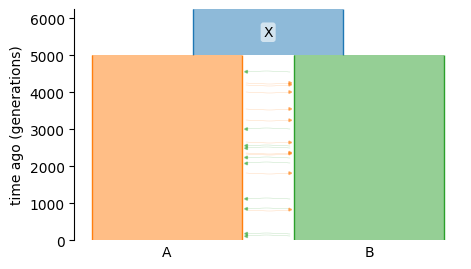

In [67]:
plt.subplots(figsize=(5, 3))
demesdraw.tubes(demog, ax=plt.gca())

In [68]:
# times = [999, 800, 600, 400, 200, 0]
times = [4999, 3000, 2000, 1000, 500, 0]
ts = msprime.sim_ancestry(
    # {"A": 40, "B": 40},
    samples=[
        msprime.SampleSet(40, population=p, time=t)
        for p, t in product(["A", "B"], times)
    ],
    sequence_length=1e6,
    recombination_rate=1e-7,
    demography=msprime.Demography.from_demes(demog),
    random_seed=SEED,
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=SEED)

In [69]:
ts

In [70]:
list(ts.populations())

[Population(id=0, metadata={'description': '', 'name': 'X'}),
 Population(id=1, metadata={'description': '', 'name': 'A'}),
 Population(id=2, metadata={'description': '', 'name': 'B'})]

In [71]:
a_sample_sets = [ts.samples(1, time=t) for t in times]
b_sample_sets = [ts.samples(2, time=t) for t in times]

In [72]:
decays = []
for a, b in zip(a_sample_sets, b_sample_sets):
    decays.append(
        parallel_chunked_iterative_ld_decay_two_way(
            ts,
            max_dist=100_000,
            win_size=100,
            chunk_size=100,
            n_threads=15,
            stat="r2_ij",
            sample_sets=[a, b],
        )
    )

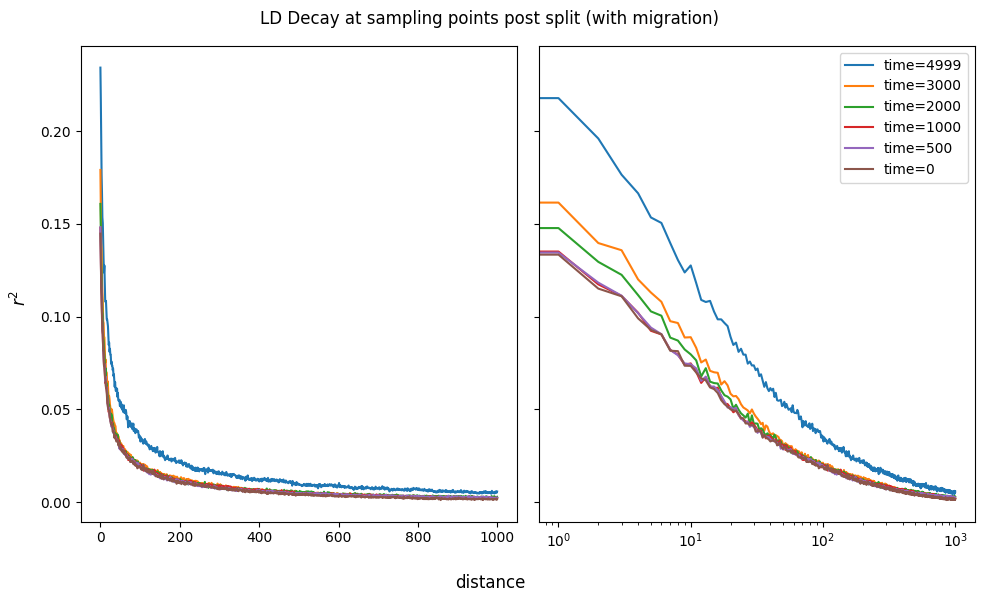

In [73]:
plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for t, d in zip(times, decays):
    plt.gcf().axes[0].plot(d, label=f"time={t}")
for t, d in zip(times, decays):
    plt.gcf().axes[1].plot(d, label=f"time={t}")
plt.legend()
plt.gcf().axes[1].set_xscale("log")
plt.gcf().supxlabel("distance")
plt.gcf().supylabel("$r^2$")
plt.suptitle("LD Decay at sampling points post split (with migration)")
plt.tight_layout()

is this the same as a pop increase?
what mig rate does this happen?